# Problem 4.4

:::{note}
This problem is mostly adapted from the following resources:
- [Data Science for Energy System Modelling: Introduction to networkx](https://fneum.github.io/data-science-for-esm/07-workshop-networkx.html)
:::

**Integrated Energy Grids**

**Problem 4.4**

** **

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install numpy networkx pandas matplotlib
```
:::

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

**a) Create a network object and calculate the average degree**

We load the simplified dataset of the European high-voltage transmission network including nodes and edges and codify it in networkX. 

In this dataset, HVDC links have been left out, and the data only shows AC transmission lines.


In [2]:
nodes = pd.read_csv('data/nodes.csv', index_col=0)
nodes.head(5)

,x,y
Bus,,
8838,-2.169800,53.243852
7157,11.927347,45.403086
1316,14.475861,40.761821
7421,4.520127,50.488619
1317,14.639282,40.688969


In [3]:
edges = pd.read_csv('data/edges.csv', index_col=0)
edges.head(5)

,bus0,bus1,s_nom,x_pu
Line,,,,
8968,1771,1774,491.556019,0.000256
11229,3792,3794,3396.205223,0.000017
11228,3793,3794,3396.205223,0.000012
11227,3793,3796,3396.205223,0.000031
8929,927,929,491.556019,0.000092


`networkx` provides a utility function `nx.from_pandas_edgelist()` to build a network from edges listed in a `pandas.DataFrame`:

In [4]:
N = nx.from_pandas_edgelist(edges, "bus0", "bus1", edge_attr=["x_pu", "s_nom"])

We can get some basic info about the graph:

In [7]:
print(N)

Graph with 3532 nodes and 5157 edges


In [8]:
degrees = [val for node, val in N.degree()]
np.mean(degrees)

2.920158550396376

**b) Add the information on the position of each node provided in 'data/nodes.csv' and make a plot of the network**

The `nodes` DataFrame provides us with the coordinates of the graph's nodes. To make the `nx.draw()` function use these coordinates, we need to bring them into a particular format.

```
{nodeA: (x, y),
 nodeB: (x, y),
 nodeC: (x, y)}
```

In [9]:
pos = nodes.apply(tuple, axis=1).to_dict()

Let's just look at the first 5 elements of the dictionary to check:

In [10]:
{k: pos[k] for k in list(pos.keys())[:5]}

{8838: (-2.16979999999999, 53.243852),
 7157: (11.9273472385104, 45.403085502256),
 1316: (14.475861, 40.761821),
 7421: (4.52012724307074, 50.4886188621382),
 1317: (14.639282, 40.688969)}

Now, we can draw the European transmission network:

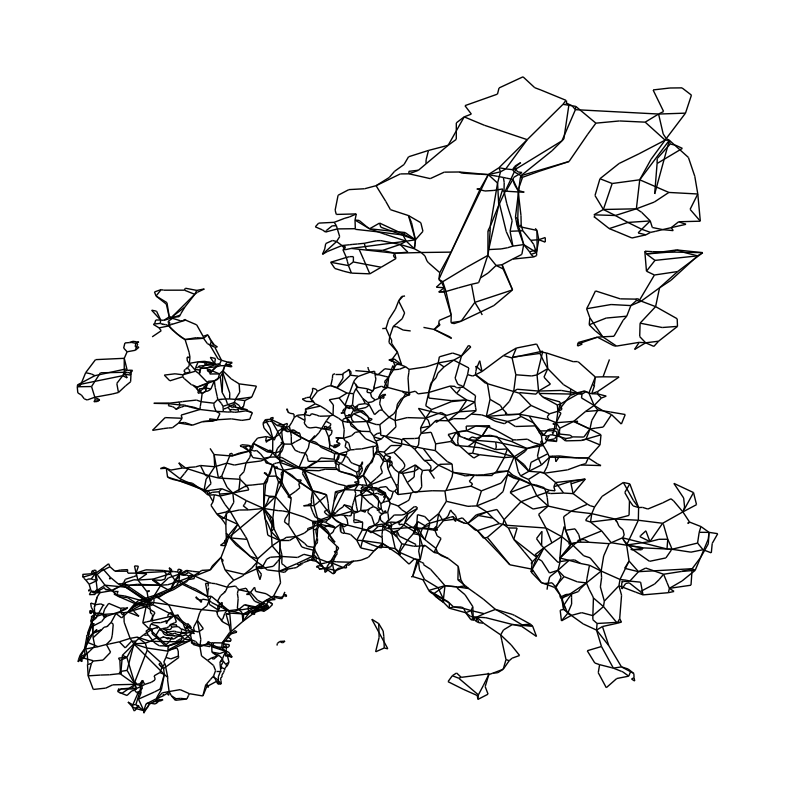

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(N, pos=pos, node_size=0)

**c) Determine how many independent network exists (these are the synchronous zones of the European transmission network)**

You can already see that not all parts of the Network are connected with each other. Ireland, Great Britain, Scandinavia, the Baltics and some Islands in the Mediterranean are not connected to the continental grid. At least not via AC transmission lines. They are through HVDC links. These subgraphs denote the different *synchronous zones* of the European transmission network:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6d/ElectricityUCTE.svg" width="600px" />

In [12]:
len(list(nx.connected_components(N)))

7

Let's build subgraphs for the synchronous zones by iterating over the connected components:

In [13]:
subgraphs = []
for c in nx.connected_components(N):
    subgraphs.append(N.subgraph(c).copy())

We can now color-code them in the network plot:

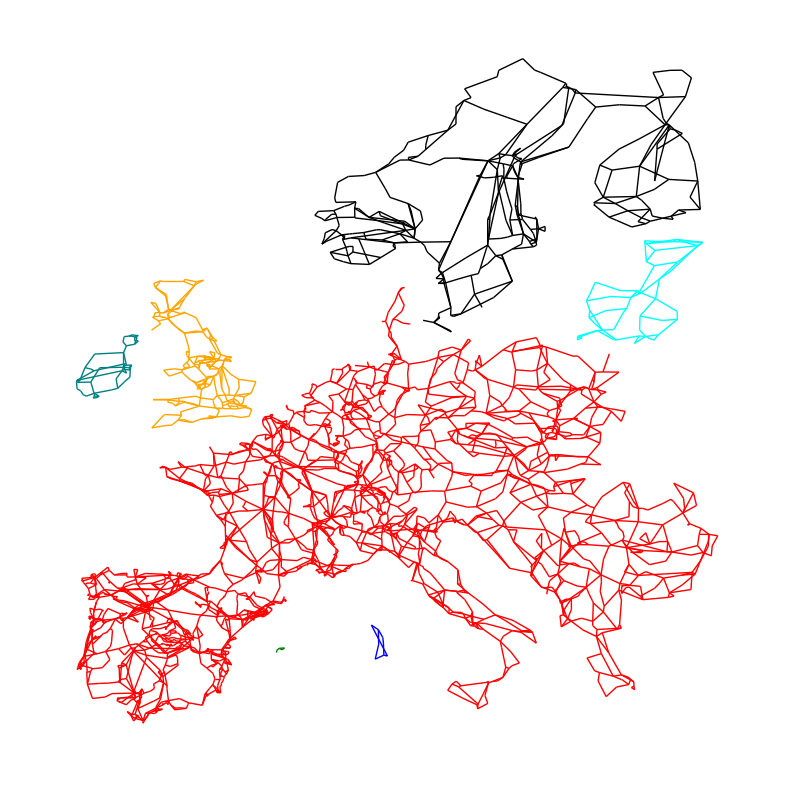

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
colors = ["red", "blue", "green", "orange", "teal", "cyan", "black"]
for i, sub in enumerate(subgraphs):
    sub_pos = {k: v for k, v in pos.items() if k in sub.nodes}
    nx.draw(sub, pos=sub_pos, node_size=0, edge_color=colors[i])

**d) For the synchronous zone corresponding to Scandinavia, calculate the number of nodes and edges. Calculate the Adjacency, Incidence and Laplacian matrix.**

In [15]:
SK = subgraphs[6]

Number of nodes and edges

In [16]:
len(SK.nodes)

304

In [17]:
len(SK.edges)

437

Adjacency matrix:

In [18]:
A = nx.adjacency_matrix(SK, weight=None).todense()

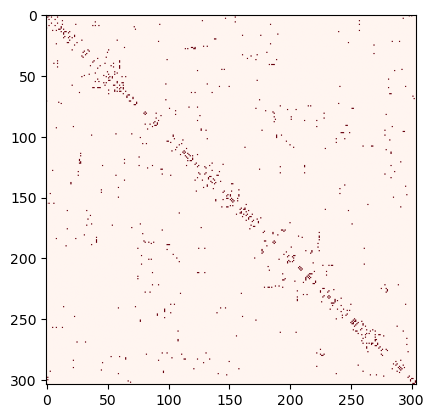

In [19]:
plt.imshow(A, cmap="Reds")

Incidence matrix:

In [20]:
K = nx.incidence_matrix(SK, oriented=True).todense()
K


array([[-1., -1., -1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.],
       [ 1.,  0.,  0., ...,  0.,  1.,  1.]])

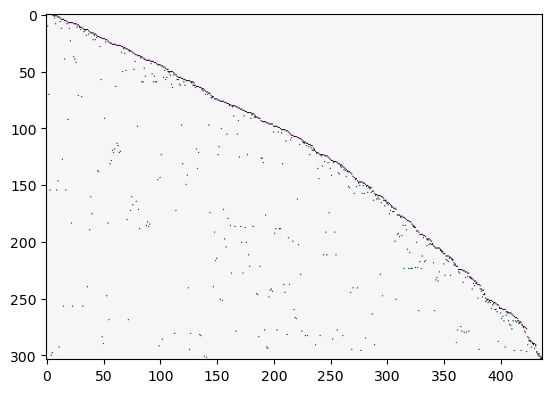

In [21]:
plt.imshow(K, cmap="PRGn")

Unweighted Laplacian:

In [22]:
L = nx.laplacian_matrix(SK, weight=None).todense()
L

array([[ 4,  0,  0, ...,  0,  0, -1],
       [ 0,  3, -1, ...,  0,  0,  0],
       [ 0, -1,  4, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  3,  0, -1],
       [ 0,  0,  0, ...,  0,  2, -1],
       [-1,  0,  0, ..., -1, -1,  3]], dtype=int32)

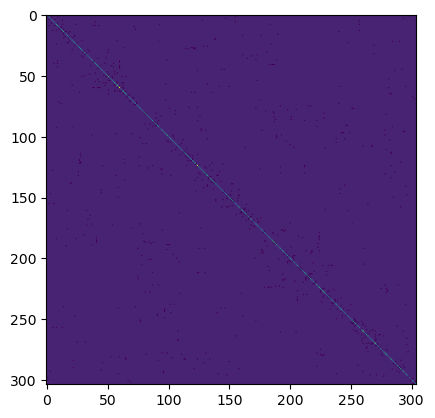

In [23]:
plt.imshow(L, cmap="viridis")

**a) Add to the network object the information on the links susceptance, calculate the weighted Laplacian (or susceptance matrix), and the Power Transfer Distribution Factor (PTDF) matrix.**

If we want to calculate the weighted Laplacian $L = KBK^\top$, we also need the diagonal matrix $B$ for the susceptances (i.e inverse of reactances; $1/x_\ell$):

In [24]:
x_pu = nx.get_edge_attributes(SK, "x_pu").values()

In [25]:
b = [1 / x for x in x_pu]

B = np.diag(b)

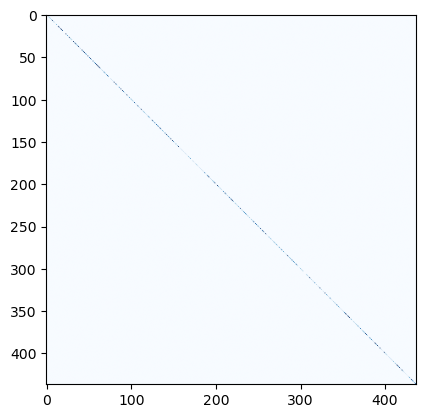

In [26]:
plt.imshow(B, cmap="Blues", vmax=30000)

Now, we can calculate the weighted Laplacian as $K_{il}\frac{1}{x_l}K_{lj}$

In [27]:
L = K.dot(B.dot(K.T))
L

array([[ 36113.57986264,      0.        ,      0.        , ...,
             0.        ,      0.        , -18151.34857397],
       [     0.        ,  31358.01814325, -10050.1263032 , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        , -10050.1263032 ,  74308.06823101, ...,
             0.        ,      0.        ,      0.        ],
       ...,
       [     0.        ,      0.        ,      0.        , ...,
         25302.61955737,      0.        , -16959.62285326],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,  35660.69258263, -25098.22536531],
       [-18151.34857397,      0.        ,      0.        , ...,
        -16959.62285326, -25098.22536531,  60209.19679254]])

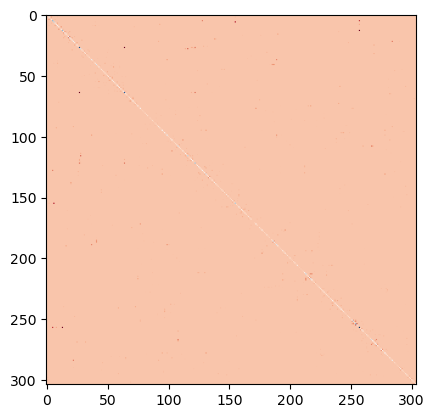

In [28]:
plt.imshow(L, cmap="RdBu")

The **PTDF** matrix measures the sensitivity of power flows in each transmission line relative to incremental changes in nodal power injections or withdrawals throughout the electricity network. 

$$p_\ell = \frac{1}{x_\ell}\sum_{i,j} K_{i\ell}  (L^{-1})_{ij} p_j$$
$$p_\ell = \sum_j \text{PTDF}_{\ell j} p_j$$

The weighted Laplacian of the network is not invertible, but we can use the [Moore Penrose pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse)

In [29]:
L_inv = np.linalg.pinv(L)

Now, we can calculate the PTDF matrix

In [30]:
PTDF = (B.dot(K.T)).dot(L_inv)

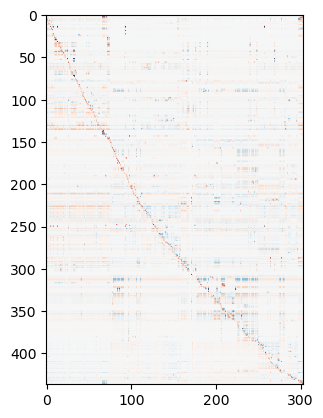

In [31]:
plt.imshow(PTDF, cmap="RdBu", vmin=-1, vmax=1)

**b) Assuming that power injection in the nodes increases linearly from -1 in the first node to +1 in the last node, calculate and plot the power flows in the network.**

In [34]:
p_i = np.linspace(-1, 1, len(SK.nodes))
p_i[:10]

array([-1.        , -0.99339934, -0.98679868, -0.98019802, -0.97359736,
       -0.9669967 , -0.96039604, -0.95379538, -0.94719472, -0.94059406])

In [35]:
p_i.sum()

0.0

In [36]:
p_l = PTDF.dot(p_i)
p_l[:10]

array([ 2.80121239,  0.        , -0.8157839 , -0.98462273,  0.19133233,
        6.5928154 , -5.78994263, -2.46201253, -1.48532332, -0.85500233])

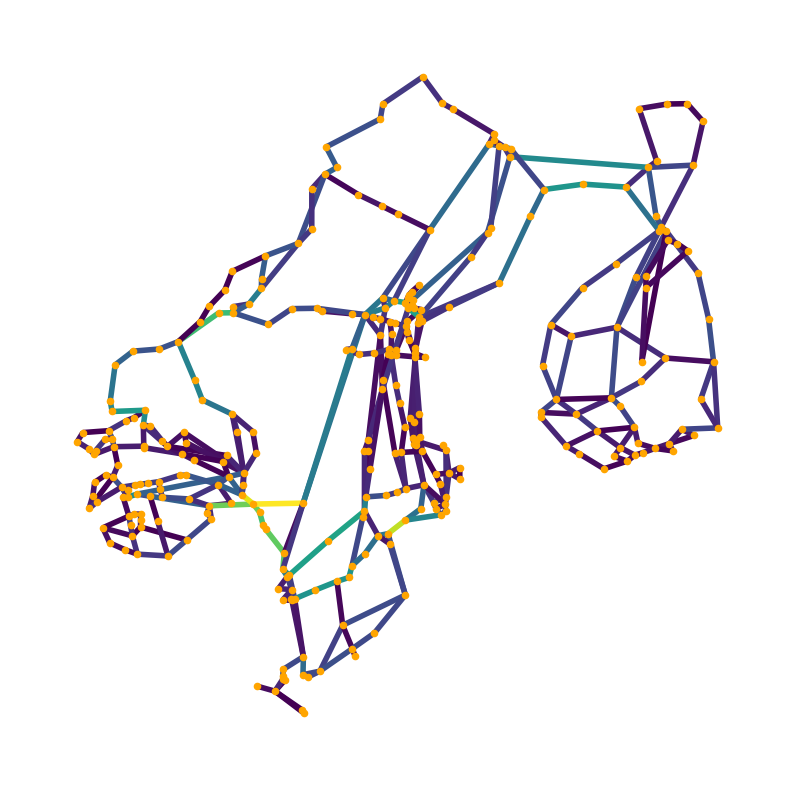

In [37]:
abs_p_l = np.abs(p_l)
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(SK, 
        with_labels=False, 
        ax=ax, 
        pos=pos, 
        node_color="orange", 
        node_size=20,
        font_weight="bold",  
        edge_color=abs_p_l, 
        width=4)